# Dissatisfuction Data Analysis_1
Focusing on gender issues, we extract dissatisfaction data whose content includes the words "男(male)" and "女 (female)".

In [26]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fname1 = '/Users/goda/Desktop/Dissatisfaction/data/table-posts.csv'
data = pd.read_csv(fname1) 

fname2 = '/Users/goda/Desktop/Dissatisfaction/data/table-user-profiles.csv'
user = pd.read_csv(fname2)

## Data
In this work, we used data provided by a Japanese company that buys negative opinions related to
uncomfortable experiences from individuals, see K. Mitsuzawa, et al. (2016) FKC Corpus: a Japanese
Corpus from New Opinion Survey Service.

### Convert the posting time
Convert the posting time to UNIX time, and rewrite it as the elapsed time (the number of days that have elapsed including seconds).

In [28]:
data['created_at_unix'] = (pd.to_datetime(data['created_at']).astype(int) // 10**9 - min(pd.to_datetime(data['created_at']).astype(int)) // 10**9)/(60*60*24)
data = data.sort_values(by="created_at_unix", ascending=True).reset_index().drop('index', axis=1)
data

,post_id,user_id,category,sub_category,company,branch,product,text,created_at,created_at_unix
0,27,22599,政治・行政,地方行政,市役所,NaN,国民健康保険,収入がゼロでも徴収される糞制度。,2015-03-18 13:35:42,0.000000
1,28,63143,アウトドア・スポーツ,その他,三菱自動車販売,NaN,ekスペース,雨の日トランクを開けて荷物を積み、トランクを閉めたら溜まった雨水が流れ落ちて頭からびしょ濡れ...,2015-03-18 13:49:32,0.009606
2,29,63143,ファッション,その他,ユニクロ,NaN,ヒートテック,静電気が凄すぎる,2015-03-18 13:53:08,0.012106
3,30,47681,美容・健康,その他,NaN,NaN,NaN,医者が処方する薬が病院によって量が違いすぎる。,2015-03-18 13:59:24,0.016458
4,31,47681,ペット,ペットフード・ペット用品,NaN,NaN,NaN,どこのメーカーもいいことしか書かないのでいい悪いがわからない。肉類、穀類など曖昧な表記を廃止...,2015-03-18 14:02:12,0.018403
...,...,...,...,...,...,...,...,...,...,...
5248815,5751730,50161,食品・飲料,その他,NaN,NaN,ミツカン酢,いつもドバッと出てしまうので、注ぎ口を小さくしてほしい,2017-03-12 09:19:20.830899,724.821968
5248816,5751731,33080,デジタル・家電,その他,NaN,NaN,NaN,色んな充電器があって、どれがなんのものかわからなくなった。,2017-03-12 09:19:36.790659,724.822153
5248817,5751732,162938,暮らし・住まい,賃貸,NaN,NaN,騒音問題,隣室の住人の騒音が酷い。真夜中に夫婦喧嘩。子供の泣き声。大家に相談するも解決せず。どうにかし...,2017-03-12 09:19:41.738646,724.822211
5248818,5751733,135198,暮らし・住まい,ベビー用品,ピジョン,購入頻度が減った,ベビー麦茶,量が多い。飲みきりサイズ(50ml)を出してほしい,2017-03-12 09:19:48.442002,724.822292


### Labeling
Adding sex and age to the data. (remove NA data)

In [30]:
sorted_user = user.sort_values(by="user_id", ascending=True).reset_index()

In [31]:
def binary_search(list, item):
    low = 0
    high = list.shape[0] - 1
    while low <= high:  
        mid = (low + high) //2
        guess = list[mid]
        if guess == item: 
            return mid
        if guess > item:
            high = mid -1
        else:
            low = mid + 1

    return None

In [32]:
gender_list = []
birth_list = []

for i in range(data.shape[0]):
    user_idx = binary_search(sorted_user.iloc[:, 1], data.iloc[i, 1])
    if user_idx != None:
        gender_list.append(sorted_user.iloc[user_idx, 2])
        if type(sorted_user.iloc[user_idx, 3]) == str:
            birth_list.append(int(sorted_user.iloc[user_idx, 3][:4]))
        else:
            birth_list.append(sorted_user.iloc[user_idx, 3])
    else:
        gender_list.append(None)
        birth_list.append(None)

In [33]:
data["gender"] = gender_list
data["birth"] = birth_list
data = data.reset_index().drop('index', axis=1)

Label them as follows. (Age at the time of posting.)

1.Female：0〜19\
2.Female：20〜29\
3.Female：30〜39\
4.Female：40〜49\
5.Female：50〜59\
6.Female：60〜\
7.Male：0〜19\
8.Male：20〜29\
9.Male：30〜39\
10.Male：40〜49\
11.Male：50〜59\
12.Male：60〜\

In [35]:
all_idx = []
nan_list = []

for i in range(data.shape[0]):  
    if 0 <= int(data.iloc[i,8][:4]) - data.iloc[i,11] < 20 and data.iloc[i,10] == "女" :
        all_idx.append(1)
    elif 20 <= int(data.iloc[i,8][:4]) - data.iloc[i,11] < 30 and data.iloc[i,10] == "女" :
        all_idx.append(2)
    elif 30 <= int(data.iloc[i,8][:4]) - data.iloc[i,11] < 40 and data.iloc[i,10] == "女" :
        all_idx.append(3)
    elif 40 <= int(data.iloc[i,8][:4]) - data.iloc[i,11] < 50 and data.iloc[i,10] == "女" :
        all_idx.append(4)
    elif 50 <= int(data.iloc[i,8][:4]) - data.iloc[i,11] < 60 and data.iloc[i,10] == "女" :
        all_idx.append(5)
    elif 60 <= int(data.iloc[i,8][:4]) - data.iloc[i,11] and data.iloc[i,10] == "女" :
        all_idx.append(6)
    
    elif 0 <= int(data.iloc[i,8][:4]) - data.iloc[i,11] < 20 and data.iloc[i,10] == "男" :
        all_idx.append(7)
    elif 20 <= int(data.iloc[i,8][:4]) - data.iloc[i,11] < 30 and data.iloc[i,10] == "男" :
        all_idx.append(8)
    elif 30 <= int(data.iloc[i,8][:4]) - data.iloc[i,11] < 40 and data.iloc[i,10] == "男" :
        all_idx.append(9)
    elif 40 <= int(data.iloc[i,8][:4]) - data.iloc[i,11] < 50 and data.iloc[i,10] == "男" :
        all_idx.append(10)
    elif 50 <= int(data.iloc[i,8][:4]) - data.iloc[i,11] < 60 and data.iloc[i,10] == "男" :
        all_idx.append(11)
    elif 60 <= int(data.iloc[i,8][:4]) - data.iloc[i,11] and data.iloc[i,10] == "男" :
        all_idx.append(12)
    else:
        nan_list.append(i)

data = data.drop(nan_list)
data["label"] = all_idx

In [37]:
data = data.reset_index().drop('index', axis=1)

In [17]:
num_all = []
for i in range(1,13):
    num_all.append(np.sum(data['label'] == i))
    print("label " + str(i) + " : " + str(num_all[-1]))
          
data

label 1 : 89329
label 2 : 986184
label 3 : 1602195
label 4 : 934134
label 5 : 300933
label 6 : 63241
label 7 : 67415
label 8 : 290422
label 9 : 417416
label 10 : 263403
label 11 : 112743
label 12 : 46103


,post_id,user_id,category,sub_category,company,branch,product,text,created_at,created_at_unix,gender,birth,label
3,30,47681,美容・健康,その他,NaN,NaN,NaN,医者が処方する薬が病院によって量が違いすぎる。,2015-03-18 13:59:24,0.016458,男,1976.0,9
4,31,47681,ペット,ペットフード・ペット用品,NaN,NaN,NaN,どこのメーカーもいいことしか書かないのでいい悪いがわからない。肉類、穀類など曖昧な表記を廃止...,2015-03-18 14:02:12,0.018403,男,1976.0,9
5,32,47681,デジタル・家電,タブレットPC・スマートフォン,Apple,NaN,iPhone5s,充電ケーブル・データ同期ケーブルが高い。高すぎる。高額。,2015-03-18 14:11:58,0.025185,男,1976.0,9
7,34,47681,外食・店舗,コンビニ・スーパーマーケット,ファミリーマート,NaN,男のシリーズ,味がいいので食べたいけど食べきれないくらい量が多すぎていやだ。男だけど食べきれない。男だから...,2015-03-18 14:21:49,0.032025,男,1976.0,9
8,36,47681,アウトドア・スポーツ,その他,日産,NaN,セレナ,週末しか乗らないのにすでにシートのスポンジがくたくたで硬くなった。,2015-03-18 14:27:23,0.035891,男,1976.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5248815,5751730,50161,食品・飲料,その他,NaN,NaN,ミツカン酢,いつもドバッと出てしまうので、注ぎ口を小さくしてほしい,2017-03-12 09:19:20.830899,724.821968,女,1978.0,3
5248816,5751731,33080,デジタル・家電,その他,NaN,NaN,NaN,色んな充電器があって、どれがなんのものかわからなくなった。,2017-03-12 09:19:36.790659,724.822153,女,1988.0,2
5248817,5751732,162938,暮らし・住まい,賃貸,NaN,NaN,騒音問題,隣室の住人の騒音が酷い。真夜中に夫婦喧嘩。子供の泣き声。大家に相談するも解決せず。どうにかし...,2017-03-12 09:19:41.738646,724.822211,男,1991.0,8
5248818,5751733,135198,暮らし・住まい,ベビー用品,ピジョン,購入頻度が減った,ベビー麦茶,量が多い。飲みきりサイズ(50ml)を出してほしい,2017-03-12 09:19:48.442002,724.822292,女,1980.0,3


### Extracting Gender Data

In [39]:
idx = []

for i in range(data.shape[0]):
    if("男" in data.iloc[i, 7] and "女" in data.iloc[i, 7]):
        continue
    idx.append(i)
    
gender = data.drop(idx)

In [40]:
gender = gender.reset_index().drop('index', axis=1)
gender.to_csv("gender_data_12.csv")

In [41]:
num_gender = []
for i in range(1,13):
    num_gender.append(np.sum(gender['label'] == i))
    print("label " + str(i) +" : " + str(num_gender[-1]))

gender

label 1 : 402
label 2 : 4626
label 3 : 7760
label 4 : 4823
label 5 : 1528
label 6 : 337
label 7 : 254
label 8 : 1104
label 9 : 1849
label 10 : 1006
label 11 : 656
label 12 : 208


,post_id,user_id,category,sub_category,company,branch,product,text,created_at,created_at_unix,gender,birth,label
0,1038,85640,人間関係,その他,NaN,NaN,NaN,特殊な女の付き合いが面倒。\nそれなのに、男も女化している人が増えてきて、相手をするのが面倒。,2015-03-24 13:49:52,6.009838,女,1980.0,3
1,1065,84272,暮らし・住まい,その他,トライアル,NaN,見切り値引きや見切り品について,タイミングが遅い!24時間営業だからといってあれはひどい。生鮮品野菜の見切り品コーナーは特に...,2015-03-24 14:16:40,6.028449,男,1980.0,9
2,1341,4635,外食・店舗,ファーストフード,吉野家,NaN,NaN,男女2人で利用したところ、「デートでこんなとこ来るとか」とひそひそ話される声が聞こえて不愉快でした,2015-03-24 23:50:41,6.427072,女,1990.0,2
3,1574,95425,暮らし・住まい,その他,NaN,NaN,NaN,大家のセクハラ発言。二人目はまだか、最近見ないが二人目できたのか、女は嫁に行くから男を産まな...,2015-03-25 06:20:37,6.697859,女,1983.0,3
4,2503,125977,人間関係,その他,NaN,NaN,平等,男女平等という言葉を聞きますが、平等は特定の人たちの待遇を優遇するモノだと思いません!\n平...,2015-03-26 09:38:25,7.835220,男,1990.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24548,5725073,1009,趣味・エンタメ,映画・ミュージカル,TOHOシネマズ,NaN,メンズデー,全国的にメンズデーを導入してほしい。\n女性差別ばかり問題視されてる、男性に対する差別だ,2017-03-08 08:45:05.339577,720.798183,男,1985.0,9
24549,5725127,148807,ファッション,服(メンズ),NaN,不便/機能面,NaN,アンクルパンツとやら、女性用も大概だらしなく見えるが、男性用だと本当に丈が足りていないだけに...,2017-03-08 08:54:58.365662,720.805046,女,1984.0,3
24550,5725159,73272,美容・健康,エステ・美容院,癒しガーデン,高田馬場,カーテンの仕切りの意味がない,何度もリピートするほど、気に入っているお店で、施術もとてもいいけど、男女共用のサロンでカーテ...,2017-03-08 08:59:46.581936,720.808380,女,1987.0,3
24551,5725174,61061,業界・業種,製造業,常盤薬品工業,NaN,眠眠打破のラジオCM,餃子屋さん編。男性だか女性だか判別できない声がいやです。おそらく女性だと思われますが、ハッ!...,2017-03-08 09:03:10.782936,720.810741,女,1962.0,5


In [42]:
Nt_g = []

for i in range(1, 13):
    Nt_g.append([0, i])

for i in range(1, gender.shape[0]):
    Nt_g.append([gender["created_at_unix"][i], gender["label"][i]])

Nt_g = np.array(Nt_g)
Nt_g[:15]

array([[ 0.        ,  1.        ],
       [ 0.        ,  2.        ],
       [ 0.        ,  3.        ],
       [ 0.        ,  4.        ],
       [ 0.        ,  5.        ],
       [ 0.        ,  6.        ],
       [ 0.        ,  7.        ],
       [ 0.        ,  8.        ],
       [ 0.        ,  9.        ],
       [ 0.        , 10.        ],
       [ 0.        , 11.        ],
       [ 0.        , 12.        ],
       [ 6.02844907,  9.        ],
       [ 6.42707176,  2.        ],
       [ 6.6978588 ,  3.        ]])

In [43]:
def Data_plot_with_label(arrivals, dim):
    label = ["(f 0-19)", "(f 20-29)", "(f 30-39)", "(f 40-49)", "(f 50-59)", "(f 60-)", "(m 0-19)", "(m 20-29)", "(m 30-39)", "(m 40-49)", "(m 50-59)", "(m 60-)"]

    # plot用の画面分割
    fig = plt.figure(figsize=(20, 10))
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    gs = gridspec.GridSpec(2,dim//2)

    t = arrivals

    for i in range(dim//2):
        time = t[t.T[:][1]==i+1]
        time = time.T[:][0]

        N = np.append(np.array(range(len(time)-1)), len(time)-2)

        ax = fig.add_subplot(gs[0,i])
        plt.subplot(gs[0,i])
        ax.plot(time, N,  color='red', drawstyle='steps-post')
        plt.ylabel("$N_t^{%d}$ " %(i+1),fontsize=12)
        plt.xlabel("$t$ "+"(day)",fontsize=12)
        ax.set_title("Group %d " %(i+1) + label[i],fontsize=15)
        plt.subplots_adjust(top=0.9)
        ax.grid()
        
    for i in range(dim//2, dim):
        time = t[t.T[:][1]==i+1]
        time = time.T[:][0]

        N = np.append(np.array(range(len(time)-1)), len(time)-2)

        ax = fig.add_subplot(gs[1,i-dim//2])
        plt.subplot(gs[1,i-dim//2])
        ax.plot(time, N,  color='red', drawstyle='steps-post')
        plt.ylabel("$N_t^{%d}$ " %(i+1) ,fontsize=12)
        plt.xlabel("$t$ "+"(day)",fontsize=12)
        ax.set_title("Group %d " %(i+1) + label[i],fontsize=15)
        plt.subplots_adjust(top=0.9)
        ax.grid()

    fig.suptitle('Plot of each category', fontsize=25)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


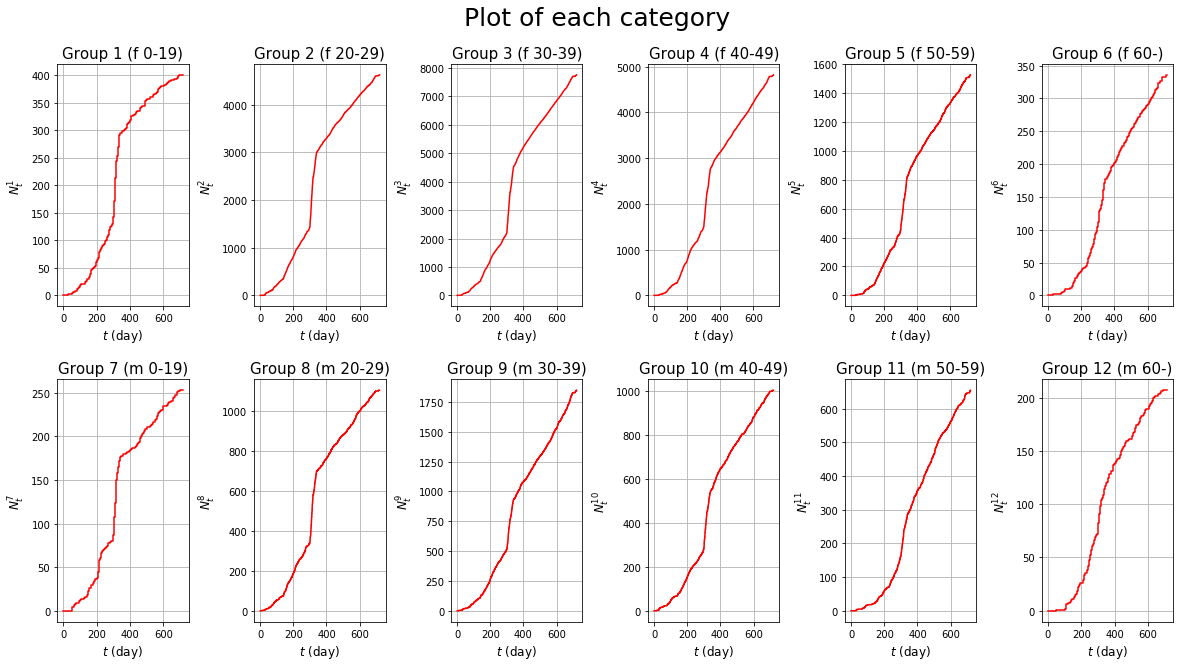

In [44]:
Data_plot_with_label(Nt_g, 12)

Plotting after 400 days. It seems stable.

Percentage of the number of posts on gender issues in overall posts

In [45]:
for i in range(1,13):
    print("label " + str(i) +" : " + str(round(num_gender[i-1]/num_all[i-1]*100,4)))

label 1 : 0.45
label 2 : 0.4691
label 3 : 0.4843
label 4 : 0.5163
label 5 : 0.5078
label 6 : 0.5329
label 7 : 0.3768
label 8 : 0.3801
label 9 : 0.443
label 10 : 0.3819
label 11 : 0.5819
label 12 : 0.4512
